## Spatiotemporal variation in Nitrogen Wet Deposition and Precipitation in New Hampshire

@author = Paola Miramontes
@date = 2025-10-20
@license = MIT -- https://opensource.org/licenses/MIT

## INTRODUCTION
Nitrogen (N) deposition is essential to nutrient cycling and transport between atmospheric, terrestrial, and aquatic ecosystems.
Studying N wet deposition is particularly important because it directly influences water quality, soil processes, and ecosystem 
productivity. The amount and type of N deposited can be influenced by multiple factors, including seasonal patterns, emission 
sources, and atmospheric transport (Murray & Wymore, 2024; Nanus et al., 2018; Wetherbee & Mast, 2016).

While N deposition has been studied at regional and global scales, less focus has been on small, local scale variation. A large part of this is due to assumptions that N deposition has little to no variation at smaller scales, however, weather paterns and geographical differences can affect how much precipitaiton and the type of precipitation chemistry that is deposited within a certain area.

Understanding these relationships and identifying the key drivers of nitrogen wet deposition across temporal and spatial scales 
will help refine management strategies aimed at mitigating the harmful effects of excess or limited N deposition to terrestrial 
and aquatic ecosystems.

## Research question and hypothesis
### Research questions: 
Q1: How does nitrogen wet deposition vary intrannually and interannually in New Hampshire?
and/or how do precipitation patterns influence nitrogen wet deposition?

Q2: How does precipitation amount and intensity vary spatially across New Hampshire?

### Hypothesis: 
H1: Interannual variation: Different nitrogen species peak at different times of the year, with NO₃⁻ peaking in winter and NH₄⁺ and DON peaking in summer. Interannual variation: Over multiple years, NO₃⁻ deposition has decreased, while NH₄⁺ and DON deposition have increased, consistent with regional emission trends observed in previous studies (Murray et al, 2022).

H2: Total precipitation and intensity have increased over time, while individual event intensity differs between sites, with higher-elevation sites receiving more total precipitation and higher intensity events.

## Study site description
### Thompson Farm (TF) site:

### Hubbard Brook (HB) site:
 
![NH_WetDepCollectors](TF_HB_Map.jpg)
Figure 1. Map of location of wet deposition collectors in Hubbard Brook watershed and Thompson Farm (within Lampre River watershed). Maps modified from Wymore et al. 2021 and https://hubbardbrook.org/online-book-chapter/the-hubbard-brook-ecosystem-study-site-history-and-research-approaches/

### Data Description
Weekly Hubbard Brook wet deposition data from the National Atmospheric Deposition Program (NADP) from 1978-2025.
Thompson Farm weekly wet deposition chemistry from 2004-2021.

**I was using precipitation data for each site but I want to implement what we did in Lab 10 and look at spatial variability in precipitation for the entire state**

### Cleaning wet dep chemistry data for TF and HB
This script imports wet deposition chemistry data from the NADP for Thompson Farm (TF2) and for Hubbard Brook (NH02). Each dataset is cleaned and detection limit corrected. HB data has weekly/event precipitation values while weekly/event TF precipitation is estimated using Climate Reference Network (CRN) values.

In [2]:
#%%Import libraries
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np
import os
from pathlib import Path
import calendar
import seaborn as sns


#%%Import data
#Import raw data

# Subdirectory to data folder
cd = Path(os.getcwd())
data = cd / 'data'

TF_file = data / '20241022_Lamprey_Precipitation.csv'
QAQC_file = data / '20211025 Lamprey Precipitation Query V4 QAQC.csv'
HB_file = data / 'NTN-nh02-w-s-mg.csv'
CRN_file = data / '20031001 to 20210422 CRN Data UNHIDs Filled.csv'

# Load data
all_dep = pd.read_csv(TF_file)
QAQC = pd.read_csv(QAQC_file)
HB = pd.read_csv(HB_file)
CRN = pd.read_csv(CRN_file, low_memory=False)

#%%Merge TF df to clean
#Rename the QAQC column to match all_dep
QAQC = QAQC.rename(columns={"UNHID#": "UNH ID #"})

#Merge on 'UNH ID #' using a left join (keep all raw data rows)
merged_dep = pd.merge(all_dep, QAQC, on="UNH ID #", how="left")

#%%Subset df
# Make sure Year is numeric
merged_dep["Year"] = pd.to_numeric(merged_dep["Year"])

#Subset: data only for TF
TF_dep = merged_dep[merged_dep["Sample Name"] == "TF2"].copy()

#%%Clean data

######Clean data: Fields for DOC, TDN, DON, NO3, NH4

#For each variable 1) filter for data flags (keep only 0, 2), clean for 1/2 DL

#DOC (NPOC mgC/L) DL limits 2002 - 2014 = 0.1, 2014-present = 0.1
TF_dep["NPOCf"] = pd.to_numeric(TF_dep["NPOCf"], errors="coerce")
TF_dep["NPOC_clean"] = np.where(TF_dep["NPOCf"] <= 2, TF_dep["NPOC (mg C/L)"], np.nan)
TF_dep["NPOC_dl_corr_mgCL"] = np.where(
    ((TF_dep["Year"] < 2014) & (TF_dep["NPOC_clean"] <= 0.1)), 0.05,
    np.where(((TF_dep["Year"] >= 2014) & (TF_dep["NPOC_clean"] <= 0.1)), 0.05, TF_dep["NPOC_clean"]))

#TDN (mg N/L) DL limits 2002 - 2014 = 0.07, 2014-present = 0.05
TF_dep["TDNf"] = pd.to_numeric(TF_dep["TDNf"], errors="coerce")
TF_dep["TDN_clean"] = np.where(TF_dep["TDNf"] <= 2, TF_dep["TDN (mg N/L)"], np.nan)
TF_dep["TDN_dl_corr_mgNL"] = np.where(
    ((TF_dep["Year"] < 2014) & (TF_dep["TDN_clean"] <= 0.07)), 0.035,
    np.where(((TF_dep["Year"] >= 2014) & (TF_dep["TDN_clean"] <= 0.05)), 0.025, TF_dep["TDN_clean"]))

##DON (mgN/L and calculated by subtraction) DL = 0.01 (not year dependent because calculated)
TF_dep["DONf"] = pd.to_numeric(TF_dep["DONf"], errors="coerce")
TF_dep["DON_clean"] = np.where(TF_dep["DONf"] <= 2, TF_dep["DON"], np.nan)
TF_dep["DON_dl_corr_mgNL"] = np.where(TF_dep["DON_clean"] <= 0.01, 0.005, TF_dep["DON_clean"])

#NO3 (mgN/L) DL limits 2002 - 2006 = 0.005, 2006-present = 0.004
TF_dep["NO3_Combf"] = pd.to_numeric(TF_dep["NO3_Combf"], errors="coerce")
TF_dep["NO3_clean"] = np.where(TF_dep["NO3_Combf"] <= 2, TF_dep["NO3_Final"], np.nan)
TF_dep["NO3_dl_corr_mgNL"] = np.where(
    ((TF_dep["Year"] < 2006) & (TF_dep["NO3_clean"] <= 0.005)), 0.0025,
    np.where(((TF_dep["Year"] >= 2006) & (TF_dep["NO3_clean"] <= 0.004)), 0.002, TF_dep["NO3_clean"]))

#NH4 (mgN/L) DL = 0.004 (or 4ug/L)
TF_dep["NH4_Combf"] = pd.to_numeric(TF_dep["NH4_Combf"], errors="coerce")
TF_dep["NH4_clean"] = np.where(TF_dep["NH4_Combf"] <= 2, TF_dep["NH4 (ug N/L)"], np.nan)
TF_dep["NH4_mgL_clean"] = TF_dep["NH4_clean"] / 1000
TF_dep["NH4_dl_corr_mgNL"] = np.where(TF_dep["NH4_mgL_clean"] <= 0.004, 0.002, TF_dep["NH4_mgL_clean"])

#%%New df for clean precip data for TF (DL corrected and QA/QC)

#Select columns to include in final df
final_cols = [
    # Site / sample information
    'UNH ID #', 
    'Sample Name', 
    'Collection Date', 
    'Collection Time', 
    'Project_x', 
    'Sub_Project_x', 
    'Year',
    
    # DL-corrected values
    'NPOC_dl_corr_mgCL', 
    'TDN_dl_corr_mgNL', 
    'DON_dl_corr_mgNL', 
    'NO3_dl_corr_mgNL', 
    'NH4_dl_corr_mgNL',

]

# Subset df
TF_sub = TF_dep[final_cols].copy()

#Drop rows with missing data for solutes
solutes = ['NPOC_dl_corr_mgCL',
 'TDN_dl_corr_mgNL',
 'DON_dl_corr_mgNL',
 'NO3_dl_corr_mgNL',
 'NH4_dl_corr_mgNL']

TF_sub = TF_sub.dropna(subset=solutes, how="all").copy()


#%% Wrangling CRN/precip data for TF
# Combine date + time and convert to datetime
TF_sub['DateTime_end'] = pd.to_datetime(
    TF_sub['Collection Date'] + ' ' + TF_sub['Collection Time'],
    format="%d-%b-%y %I:%M:%S %p",
    errors='coerce'
)

#Create DateTime_begin as previous row's DateTime_end
TF_sub['DateTime_begin'] = TF_sub['DateTime_end'].shift(1)

#Add Month and Sampling Interval
TF_sub['Month'] = TF_sub['DateTime_begin'].dt.month.fillna(TF_sub['DateTime_end'].dt.month)
TF_sub['Sampling.Interval'] = range(1, len(TF_sub)+1)

#Convert CRN hourly data to datetime
CRN['Date_new'] = pd.to_datetime(CRN['Date_Hour_end_EST'].str.strip(), format="%m/%d/%y %H:%M", errors='coerce')

#Assign each CRN record to the correct sampling interval
CRN['Sampling.Interval'] = np.nan
for idx, row in TF_sub.iloc[1:].iterrows():  # skip first row
    mask = (CRN['Date_new'] > row['DateTime_begin']) & (CRN['Date_new'] <= row['DateTime_end'])
    CRN.loc[mask, 'Sampling.Interval'] = row['Sampling.Interval']

#Sort CRN by datetime
CRN = CRN.sort_values('Date_new')

#Sum precipitation by sampling interval
CRN_sum = (
    CRN.groupby("Sampling.Interval", dropna=False)
    .agg(precip_mm=("TF_P_wUNHfilled_mm", "sum"))
    .reset_index()
)

#Merge summed CRN precipitation with TF_sub
TF_final = pd.merge(TF_sub, CRN_sum, on="Sampling.Interval", how="left")

#Change end date column to datetime
TF_final['enddate'] = pd.to_datetime(TF_final['DateTime_end'])


#%%Clean HB data
#Convert NO3 and NH4 into mgN/L      

#Convert NH4 to mg N/L
Nu = 14.007*1000 #mg/mol
NH4u = 18.04*1000 #mg/mol
HB['NH4mgNL'] = (HB.NH4) * (Nu/NH4u)

#Convert NO3 to mg N/L
NO3u = 62.0049*1000 #mg/mol
HB['NO3mgNL'] = (HB.NO3) * (Nu/NO3u)

# Keep only rows with acceptable valcodes
valid_codes = ["w ", "wa", "wi", "wd"]

#Only keep valid samples
HB_clean = HB[HB["valcode"].isin(valid_codes)].copy()

#Change collection date colume to datetime
HB_clean['enddate'] = pd.to_datetime(HB_clean['dateOff'])

#Only keep necessary columns
HB_final = HB_clean[['siteID','labno','dateOn','dateOff','enddate','yrmonth','flagNa','flagNH4',
'NH4mgNL','flagNO3', 'NO3mgNL', 'subppt']]

## Results
#### Time series plot of weekly precipitation at each site over the entire data collection period

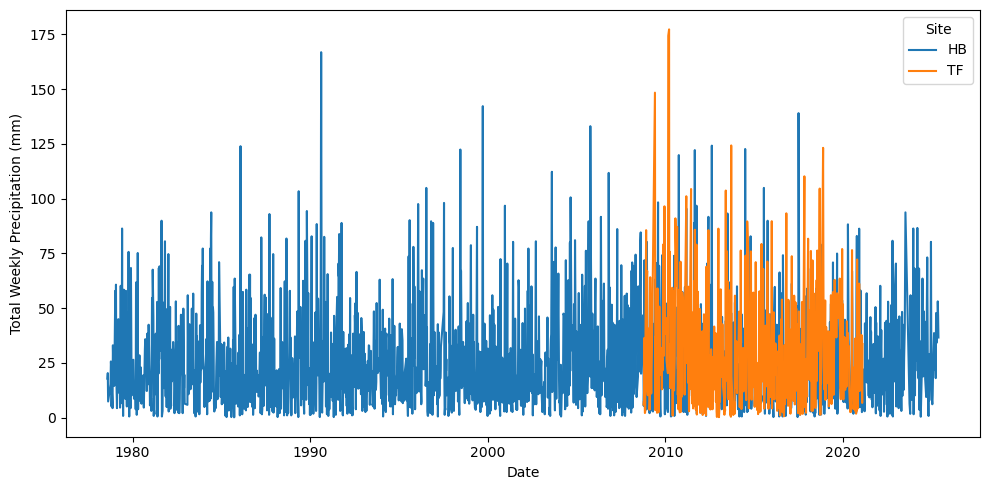

In [4]:
#%%Timeseries Plot for TF and HB weekly precipitation
fig, ax = plt.subplots(figsize=(10, 5))

# Create a list of dataframes and their site labels
sites = [
   ("HB", HB_final, "subppt") ,   #HB precipitation column
   ("TF", TF_final, "precip_mm")  #TF precipitation column
]

for site_name, df, precip_col in sites:
    # Make sure the dataframe has non-null dates
    df_plot = df.dropna(subset=['enddate', precip_col])
    ax.plot(df_plot['enddate'], df_plot[precip_col], label=site_name)

ax.set(
    xlabel='Date',
    ylabel='Total Weekly Precipitation (mm)'
)
ax.legend(title='Site')
plt.tight_layout()
plt.show()

### Combining datasets and weekly precipitation for overlapping data collection

In [6]:
#%% Create new TF and HB subsets with renamed columns + wateryear for concatentation
#===========TF===============
#TF subset
TF_renamed = TF_final.rename(columns={
    'DateTime_begin': 'startdate',
    'NPOC_dl_corr_mgCL': 'DOCmgCL',
    'TDN_dl_corr_mgNL': 'TDNmgNL',
    'DON_dl_corr_mgNL': 'DONmgNL',
    'NH4_dl_corr_mgNL': 'NH4mgNL',
    'NO3_dl_corr_mgNL': 'NO3mgNL'
})

# Add site
TF_renamed['site'] = "TF"

# Select columns
TF_sub2 = TF_renamed[[
    'site',
    'startdate',
    'enddate',
    'precip_mm',
    'DOCmgCL',
    'TDNmgNL',
    'DONmgNL',
    'NO3mgNL',
    'NH4mgNL'
]].copy()

# Water year
TF_sub2['wateryear'] = np.where(
    TF_sub2['enddate'].dt.month >= 10,
    TF_sub2['enddate'].dt.year + 1,
    TF_sub2['enddate'].dt.year
)


#===========HB===============
#HB subset
HB_renamed = HB_final.rename(columns={
    'subppt': 'precip_mm'
})

# Add site
HB_renamed['site'] = 'HB'

# Convert startdate
HB_renamed['startdate'] = pd.to_datetime(HB_renamed['dateOn'], errors='coerce')

# Ensure enddate is datetime
HB_renamed['enddate'] = pd.to_datetime(HB_renamed['enddate'], errors='coerce')

# Select only columns you want
HB_sub2 = HB_renamed[[
    'site',
    'startdate',
    'enddate',
    'yrmonth',
    'precip_mm',
    'NH4mgNL',
    'NO3mgNL'
    
]].copy()

# Add wateryear
HB_sub2['wateryear'] = np.where(
    HB_sub2['enddate'].dt.month >= 10,
    HB_sub2['enddate'].dt.year + 1,
    HB_sub2['enddate'].dt.year
)

# Get min and max dates from TF data
tf_start = TF_sub2['enddate'].min()
tf_end = TF_sub2['enddate'].max()

# Keep only HB rows within TF date range
HB_sub2 = HB_sub2[(HB_sub2['enddate'] >= tf_start) & (HB_sub2['enddate'] <= tf_end)].copy()


#Combine TF and HB
combined = pd.concat([TF_sub2, HB_sub2], ignore_index=True).sort_values(['site','startdate'])

### Calculating Volume Weighted Mean (VWM) concentrations and loads for deposition chemistry

In [5]:
#%%Precipitation-weighted concentrations
#Calculate Precipitation-Weighted Concentrations for each solute by first multiplying each measured concentration by the rainfall for that ~weekly time period
#Create a second column for rainfall totals on days a solute was measured - accounts for weeks where there wasn't enough sample to run all of the analyses 

combined['yrmonth'] = (
    combined['enddate'].dt.year * 100 +
    combined['enddate'].dt.month
)

#Compute solute × precipitation (mg/L × mm) (precipitation-weighted mass columns) (numerator)
combined['TDNmgNL_mm']  = (combined['TDNmgNL']  * combined['precip_mm']).where(combined['TDNmgNL'].notna())
combined['NO3mgNL_mm']  = (combined['NO3mgNL']  * combined['precip_mm']).where(combined['NO3mgNL'].notna())
combined['NH4mgNL_mm']  = (combined['NH4mgNL']  * combined['precip_mm']).where(combined['NH4mgNL'].notna())
combined['DONmgNL_mm']  = (combined['DONmgNL']  * combined['precip_mm']).where(combined['DONmgNL'].notna())
combined['DOCmgCL_mm']  = (combined['DOCmgCL']  * combined['precip_mm']).where(combined['DOCmgCL'].notna())


#Precip for each solute (denominator) only where solute is measured
#Prevents accidentally including precipitation from rows where the solute is missing
combined['TDN_mm']  = combined['precip_mm'].where(combined['TDNmgNL'].notna())
combined['NO3_mm']  = combined['precip_mm'].where(combined['NO3mgNL'].notna())
combined['NH4_mm']  = combined['precip_mm'].where(combined['NH4mgNL'].notna())
combined['DON_mm']  = combined['precip_mm'].where(combined['DONmgNL'].notna())
combined['DOC_mm']  = combined['precip_mm'].where(combined['DOCmgCL'].notna())

#Group by site and month, sum numerator & denominator
monthly_weighted = combined.groupby(['site','yrmonth']).agg({
    'TDNmgNL_mm':'sum',
    'NO3mgNL_mm':'sum',
    'NH4mgNL_mm':'sum',
    'DONmgNL_mm':'sum',
    'DOCmgCL_mm':'sum',
    'TDN_mm':'sum',
    'NO3_mm':'sum',
    'NH4_mm':'sum',
    'DON_mm':'sum',
    'DOC_mm':'sum',
    'precip_mm':'sum'  # total precipitation for reference
}).reset_index()

#Calculate Volume-Weighted Mean Concentrations (mg/L)
monthly_weighted['TDN_mgL_vwm']  = monthly_weighted['TDNmgNL_mm'] / monthly_weighted['TDN_mm']
monthly_weighted['NO3_mgL_vwm']  = monthly_weighted['NO3mgNL_mm'] / monthly_weighted['NO3_mm']
monthly_weighted['NH4_mgL_vwm']  = monthly_weighted['NH4mgNL_mm'] / monthly_weighted['NH4_mm']
monthly_weighted['DON_mgL_vwm']  = monthly_weighted['DONmgNL_mm'] / monthly_weighted['DON_mm']
monthly_weighted['DOC_mgL_vwm']  = monthly_weighted['DOCmgCL_mm'] / monthly_weighted['DOC_mm']

#%%#%%Caluclate wet deposition load (mgNO3N/ha d)
# (conc * precip vol) / (collection time * watershed area) --> this eqn does not include unit conversions
# Extract year and month
monthly_weighted['year'] = monthly_weighted['yrmonth'] // 100
monthly_weighted['month'] = monthly_weighted['yrmonth'] % 100

# Days in month
monthly_weighted['days_in_month'] = monthly_weighted.apply(
    lambda row: calendar.monthrange(row['year'], row['month'])[1],
    axis=1
)

# Solutes list
solutes = ['NO3', 'NH4', 'DON', 'DOC', 'TDN']

# Calculate daily wet deposition load (mg/m²/day)
for s in solutes:
    vwm_col = f'{s}_mgL_vwm'  # numerator: VWM concentration
    mm_col  = f'{s}_mm'       # denominator: total precipitation contributing to VWM
    load_col = f'{s}_load_mg_m2_d'
    
    # Safe calculation: only compute if both columns exist and not NaN
    monthly_weighted[load_col] = (
        monthly_weighted[vwm_col] * monthly_weighted[mm_col]
    ) / monthly_weighted['days_in_month']
    
#convert mg/m²/day → kg/ha/day
for s in solutes:
    monthly_weighted[f'{s}_load_kg_ha_d'] = monthly_weighted[f'{s}_load_mg_m2_d'] * 0.01

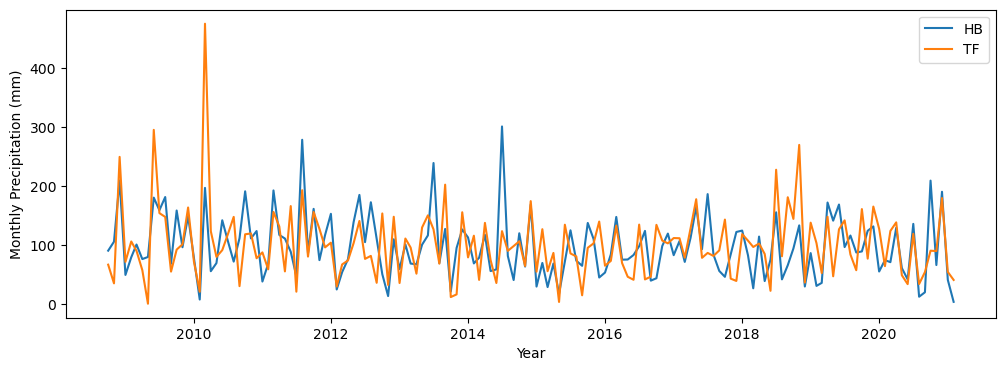

In [19]:
#%%Multi-site precipitation time series
# Convert yrmonth to a datetime (use first day of the month)
monthly_weighted['date'] = pd.to_datetime(
    monthly_weighted['yrmonth'].astype(str), format='%Y%m'
)

plt.figure(figsize=(12, 4))

for site in monthly_weighted['site'].unique():
    site_data = monthly_weighted[monthly_weighted['site'] == site]
    plt.plot(site_data['date'], site_data['precip_mm'], linestyle='-', label=site)

plt.xlabel('Year')
plt.ylabel('Monthly Precipitation (mm)')
plt.legend()
plt.show()


### Examining Interannual Variability 

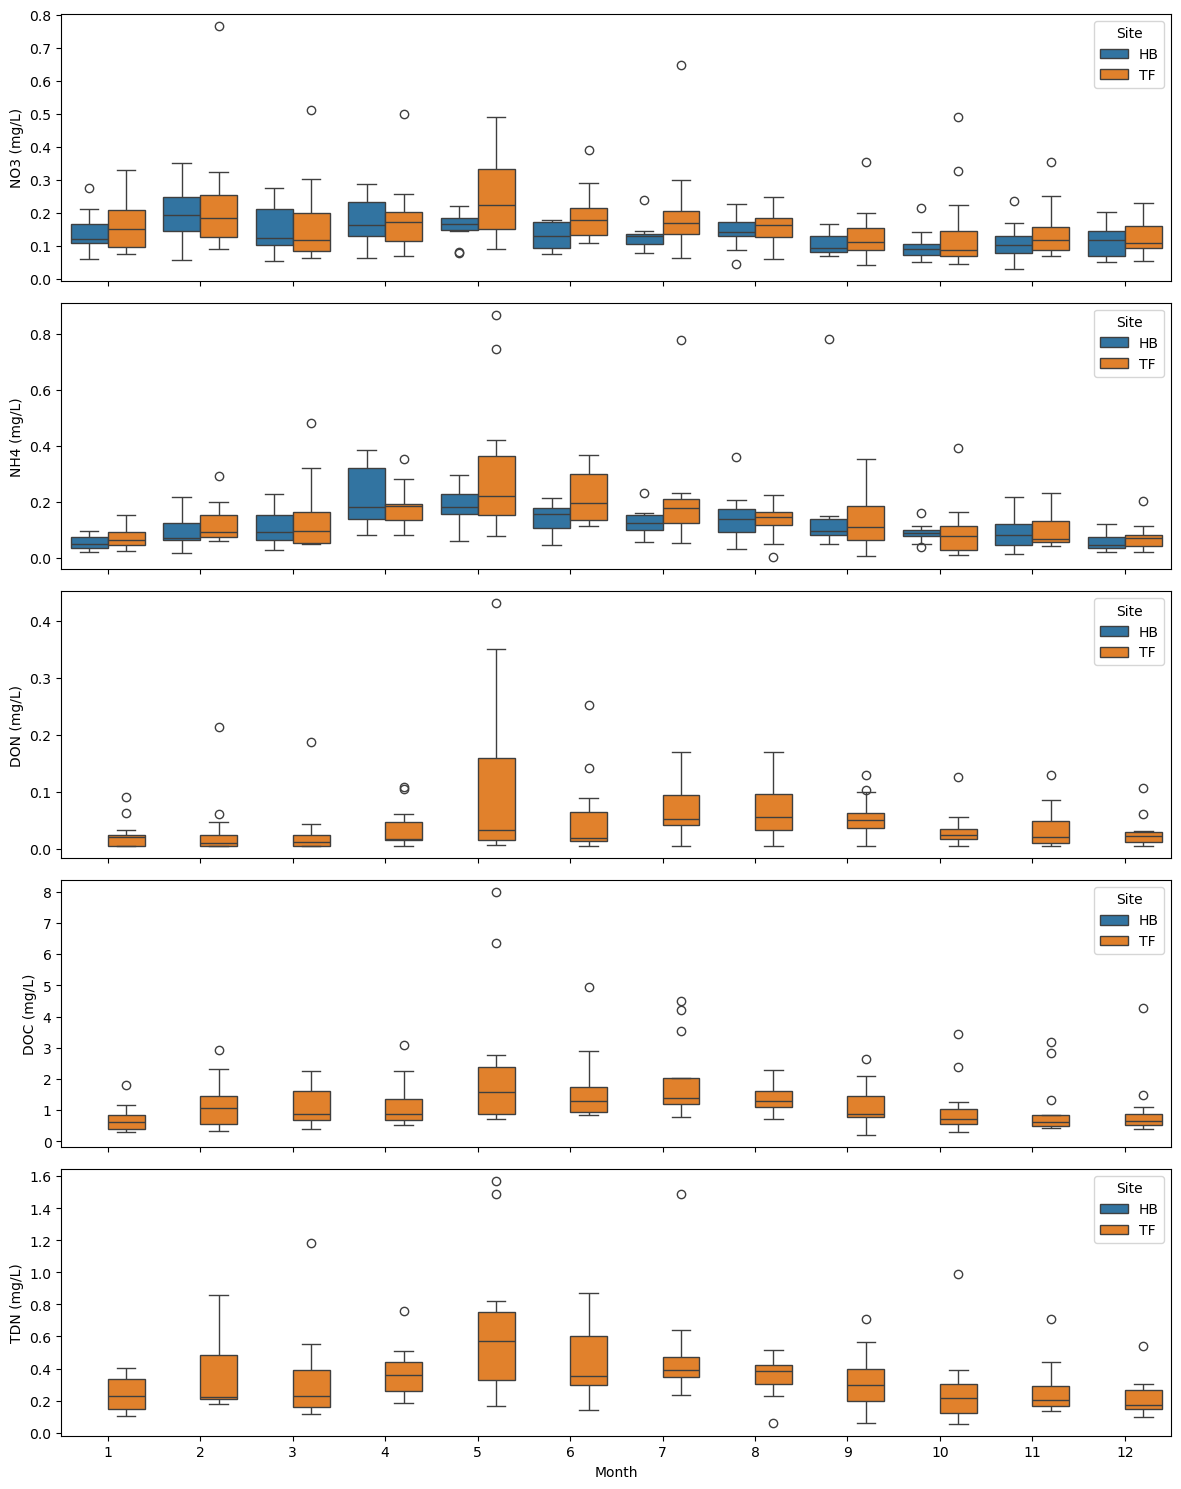

In [15]:
#%%Intrannual varability
fig, axes = plt.subplots(len(solutes), 1, figsize=(12, 3*len(solutes)), sharex=True)

for ax, s in zip(axes, solutes):
    vwm_col = f"{s}_mgL_vwm"
    
    sns.boxplot(
        data=monthly_weighted,
        x="month",
        y=vwm_col,
        hue="site",          # <-- key addition
        ax=ax
    )

    ax.set_ylabel(f"{s} (mg/L)")
    ax.legend(title="Site")

axes[-1].set_xlabel("Month")
plt.tight_layout()
plt.show()


### Examining Interannual Variability

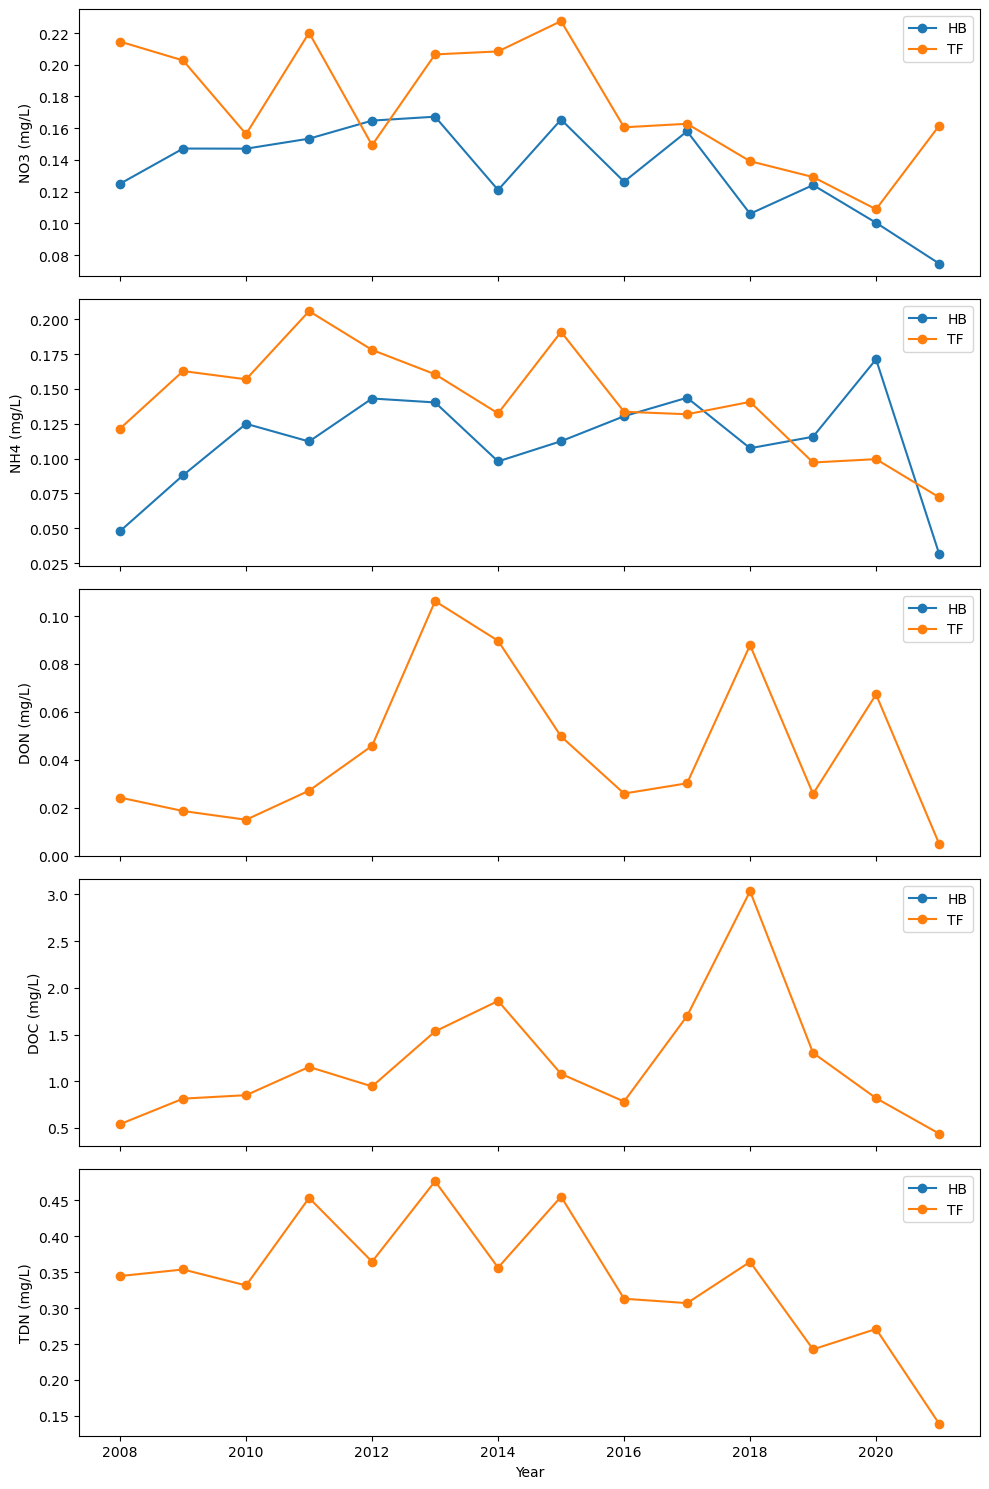

In [13]:
#%%Interannual variability
annual = monthly_weighted.groupby(['site','year']).agg({
    'NO3_mgL_vwm':'mean',
    'NH4_mgL_vwm':'mean',
    'DON_mgL_vwm':'mean',
    'DOC_mgL_vwm':'mean',
    'TDN_mgL_vwm':'mean',
}).reset_index()

fig, axes = plt.subplots(len(solutes), 1, figsize=(10, 3*len(solutes)), sharex=True)

for ax, s in zip(axes, solutes):
    for site in annual['site'].unique():
        site_data = annual[annual['site'] == site]
        ax.plot(site_data['year'], site_data[f'{s}_mgL_vwm'], marker='o', label=site)
    ax.set_ylabel(f'{s} (mg/L)')
    ax.legend()

axes[-1].set_xlabel('Year')
plt.tight_layout()
plt.show()

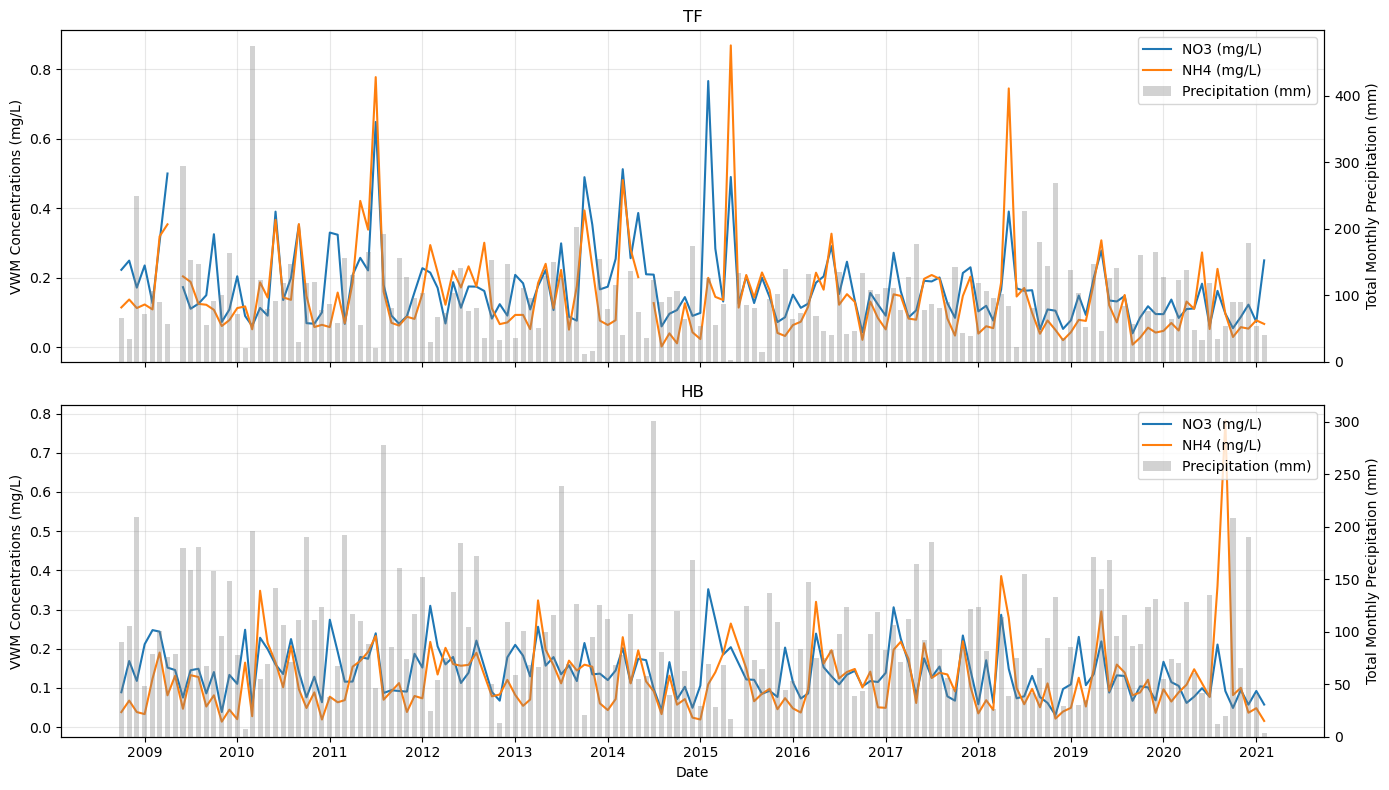

In [25]:
#%% Two-panel figure: precipitation + chemistry per site

import matplotlib.dates as mdates

#solutes to plot
solutes_to_plot = ['NO3_mgL_vwm', 'NH4_mgL_vwm']

fig, axes = plt.subplots(2, 1, figsize=(14, 8), sharex=True)
sites_order = ['TF', 'HB']

for ax, site in zip(axes, sites_order):

    df = monthly_weighted[monthly_weighted['site'] == site].copy()

    ax.set_title(f"{site}") 
    
    # Create twin axis for precipitation
    ax2 = ax.twinx()

    #=== LEFT AXIS: chemistry lines ===#
    for s in solutes_to_plot:
        ax.plot(df['date'], df[s],
                label=s.replace('_mgL_vwm', ' (mg/L)'))

    ax.set_ylabel("VWM Concentrations (mg/L)")
    ax.grid(alpha=0.3)

    #=== RIGHT AXIS: precipitation bars ===#
    ax2.bar(df['date'], df['precip_mm'],
            width=20, alpha=0.35, color='gray',
            label="Precipitation (mm)")

    ax2.set_ylabel("Total Monthly Precipitation (mm)")

    # Combined legend
    lines, labels = ax.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    ax.legend(lines + lines2, labels + labels2,
              loc='upper right')

# Shared x-axis formatting
axes[-1].set_xlabel("Date")
axes[-1].xaxis.set_major_locator(mdates.YearLocator())
axes[-1].xaxis.set_major_formatter(mdates.DateFormatter('%Y'))

plt.tight_layout()
plt.show()

## Precipitation vs solute concentrations (CQ type plot)
This will plot VWM concentrations and precipitation

## Discussion

## References